# Introduction to Generative Adversarial Networks in Keras
## Agenda

- Quick Intro to GAN's
- How can we implement GAN's in Keras
- Teaching GAN how to generate handwritten digits

<img src="images/train_14.png" alt="Image:1" title="Title text" />

# GAN Framework
Generative Adversarial Networks use two models: Generator and Discriminator. As the name suggests, both are adversaries of each other, i.e, each tries to fool the other in a minimax game.

<img src="images/gan.png" alt="Gan Framework" title="GAN Framework" />

In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt

import sys

import numpy as np

## Generator
The generator samples some values from a latent code and generates images that look like the training samples.

<img src="images/generator.png" alt="Generator Strategy" title="Generator Strategy" />

In [3]:
def build_generator():

    noise_shape = (100,)
    
    model = Sequential()
    
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    
    model.summary()
    
    noise = Input(shape=noise_shape)
    img = model(noise)
    
    return Model(noise, img)

## Discriminator
The purpose of the discriminator is to accurately predict, whether the images are real (from the training data) or fake (sampled from Generator's output). During training, the Generator tries to fool the discriminator into believing that the generated images are real. The discriminator is used only during training and is discarded after that.

<img src="images/discriminator-1.png" alt="Discriminator Strategy" title="Discriminator Strategy" />

<img src="images/discriminator-2.png" alt="Discriminator Strategy" title="Discriminator Strategy" />

In [4]:
def build_discriminator():
    img_shape = (img_rows, img_cols, channels)
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

In [5]:
# Some Hyperparameters
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
optimizer = Adam(0.0002, 0.5)



In [6]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False
# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
__________

# Training
- Training the GAN means training the generator.
- We feed latent samples to the GAN while setting the expected outcome (label) to 1 (real) as we expect the generator to produce realistic image, and we expect the discriminator to say it is real or close to real.
- When we feed a latent sample to the GAN, the generator internally produces a digit image which is then passed to the discriminator for classification.
- However, the generator initially produces garbage images, and the loss value is high.
- Back-propagation updates the generator’s weights to produce more realistic images as the training continues.

In [8]:
def train(epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = np.array([1] * batch_size)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid_y)

        # Plot the progress
        if epoch % (sample_interval/5) == 0:
            print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

In [9]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #cv2.imwrite("images/mnist_%d.png" % epoch, np.array(fig))
    plt.show(fig)
    plt.close()

C:\Users\mbilkhu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [Discriminator loss: 0.854287, acc.: 21.88%] [Generator loss: 0.828001]


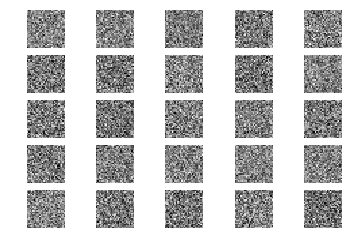

100 [Discriminator loss: 0.101747, acc.: 94.53%] [Generator loss: 3.248959]
200 [Discriminator loss: 0.398657, acc.: 78.91%] [Generator loss: 2.366006]
300 [Discriminator loss: 0.671754, acc.: 46.09%] [Generator loss: 0.642359]
400 [Discriminator loss: 0.628559, acc.: 60.16%] [Generator loss: 0.675638]
500 [Discriminator loss: 0.619214, acc.: 65.62%] [Generator loss: 0.780185]


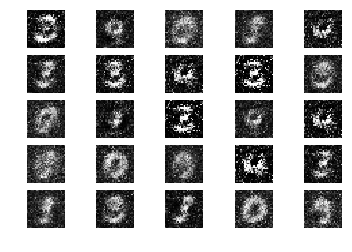

600 [Discriminator loss: 0.619475, acc.: 64.06%] [Generator loss: 0.728971]
700 [Discriminator loss: 0.645335, acc.: 61.72%] [Generator loss: 0.784582]
800 [Discriminator loss: 0.596113, acc.: 75.78%] [Generator loss: 0.882743]
900 [Discriminator loss: 0.599167, acc.: 76.56%] [Generator loss: 0.910382]
1000 [Discriminator loss: 0.596386, acc.: 71.88%] [Generator loss: 0.897122]


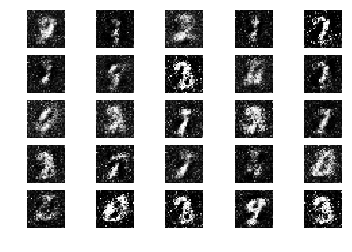

1100 [Discriminator loss: 0.618825, acc.: 67.97%] [Generator loss: 1.003827]
1200 [Discriminator loss: 0.536488, acc.: 82.03%] [Generator loss: 0.992242]
1300 [Discriminator loss: 0.561106, acc.: 81.25%] [Generator loss: 1.001063]
1400 [Discriminator loss: 0.557136, acc.: 76.56%] [Generator loss: 1.052499]
1500 [Discriminator loss: 0.576780, acc.: 70.31%] [Generator loss: 0.995290]


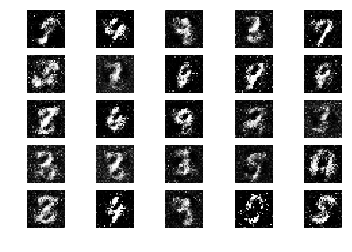

1600 [Discriminator loss: 0.608979, acc.: 71.88%] [Generator loss: 1.021202]
1700 [Discriminator loss: 0.634006, acc.: 60.94%] [Generator loss: 0.922911]
1800 [Discriminator loss: 0.587162, acc.: 73.44%] [Generator loss: 0.950560]
1900 [Discriminator loss: 0.610776, acc.: 70.31%] [Generator loss: 0.934778]
2000 [Discriminator loss: 0.648520, acc.: 62.50%] [Generator loss: 0.951005]


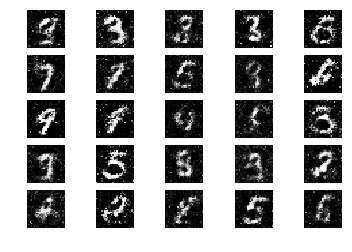

2100 [Discriminator loss: 0.633034, acc.: 69.53%] [Generator loss: 0.893062]
2200 [Discriminator loss: 0.622523, acc.: 64.84%] [Generator loss: 0.863448]
2300 [Discriminator loss: 0.631740, acc.: 64.84%] [Generator loss: 0.950061]
2400 [Discriminator loss: 0.608521, acc.: 64.84%] [Generator loss: 0.889220]
2500 [Discriminator loss: 0.628672, acc.: 62.50%] [Generator loss: 0.891849]


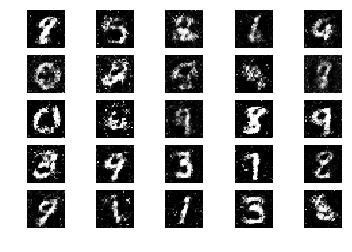

2600 [Discriminator loss: 0.608562, acc.: 71.09%] [Generator loss: 0.907253]
2700 [Discriminator loss: 0.635956, acc.: 62.50%] [Generator loss: 0.876552]
2800 [Discriminator loss: 0.608108, acc.: 67.19%] [Generator loss: 0.885820]
2900 [Discriminator loss: 0.659674, acc.: 61.72%] [Generator loss: 0.878094]
3000 [Discriminator loss: 0.634695, acc.: 67.19%] [Generator loss: 0.878382]


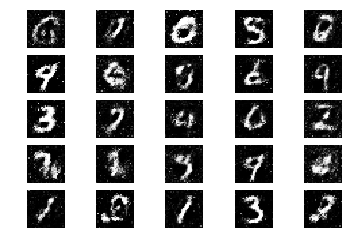

3100 [Discriminator loss: 0.662248, acc.: 55.47%] [Generator loss: 0.895831]
3200 [Discriminator loss: 0.638324, acc.: 64.84%] [Generator loss: 0.860189]
3300 [Discriminator loss: 0.663042, acc.: 60.94%] [Generator loss: 0.870050]
3400 [Discriminator loss: 0.641562, acc.: 63.28%] [Generator loss: 0.828960]
3500 [Discriminator loss: 0.676722, acc.: 57.03%] [Generator loss: 0.869026]


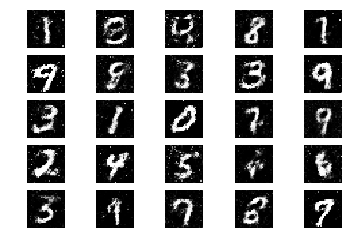

3600 [Discriminator loss: 0.628525, acc.: 65.62%] [Generator loss: 0.865080]
3700 [Discriminator loss: 0.630836, acc.: 67.19%] [Generator loss: 0.855354]
3800 [Discriminator loss: 0.647304, acc.: 59.38%] [Generator loss: 0.873163]
3900 [Discriminator loss: 0.657889, acc.: 61.72%] [Generator loss: 0.849363]
4000 [Discriminator loss: 0.679548, acc.: 56.25%] [Generator loss: 0.812591]


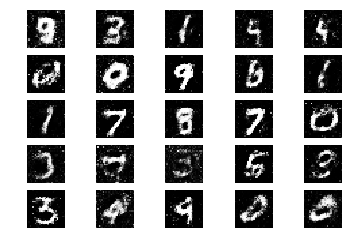

4100 [Discriminator loss: 0.623217, acc.: 70.31%] [Generator loss: 0.846851]
4200 [Discriminator loss: 0.656265, acc.: 63.28%] [Generator loss: 0.801256]
4300 [Discriminator loss: 0.682401, acc.: 55.47%] [Generator loss: 0.877227]
4400 [Discriminator loss: 0.680078, acc.: 59.38%] [Generator loss: 0.860985]
4500 [Discriminator loss: 0.687381, acc.: 55.47%] [Generator loss: 0.806658]


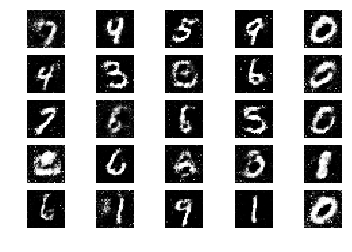

4600 [Discriminator loss: 0.665284, acc.: 63.28%] [Generator loss: 0.820227]
4700 [Discriminator loss: 0.677900, acc.: 59.38%] [Generator loss: 0.844130]
4800 [Discriminator loss: 0.710694, acc.: 50.78%] [Generator loss: 0.828754]
4900 [Discriminator loss: 0.704753, acc.: 52.34%] [Generator loss: 0.819554]
5000 [Discriminator loss: 0.677616, acc.: 58.59%] [Generator loss: 0.807828]


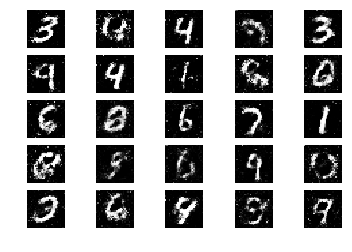

5100 [Discriminator loss: 0.655966, acc.: 60.16%] [Generator loss: 0.810422]
5200 [Discriminator loss: 0.681041, acc.: 57.03%] [Generator loss: 0.806777]
5300 [Discriminator loss: 0.670949, acc.: 57.03%] [Generator loss: 0.824859]
5400 [Discriminator loss: 0.665541, acc.: 66.41%] [Generator loss: 0.825741]
5500 [Discriminator loss: 0.678801, acc.: 55.47%] [Generator loss: 0.807452]


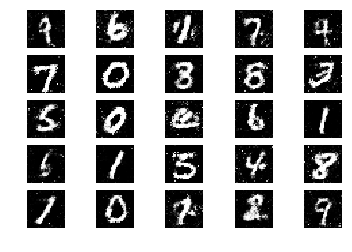

5600 [Discriminator loss: 0.647751, acc.: 62.50%] [Generator loss: 0.844728]
5700 [Discriminator loss: 0.710778, acc.: 53.12%] [Generator loss: 0.829724]
5800 [Discriminator loss: 0.686204, acc.: 54.69%] [Generator loss: 0.846833]
5900 [Discriminator loss: 0.653435, acc.: 61.72%] [Generator loss: 0.804506]
6000 [Discriminator loss: 0.716862, acc.: 48.44%] [Generator loss: 0.812256]


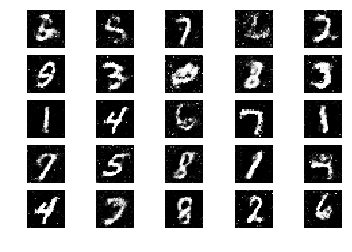

6100 [Discriminator loss: 0.713951, acc.: 49.22%] [Generator loss: 0.785034]
6200 [Discriminator loss: 0.706425, acc.: 47.66%] [Generator loss: 0.806095]
6300 [Discriminator loss: 0.679450, acc.: 58.59%] [Generator loss: 0.816308]
6400 [Discriminator loss: 0.663071, acc.: 59.38%] [Generator loss: 0.787055]
6500 [Discriminator loss: 0.708218, acc.: 55.47%] [Generator loss: 0.815809]


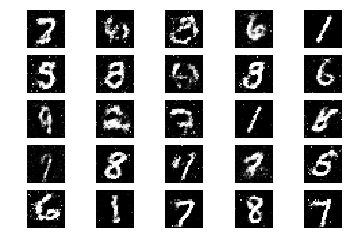

6600 [Discriminator loss: 0.678031, acc.: 55.47%] [Generator loss: 0.806946]
6700 [Discriminator loss: 0.673747, acc.: 55.47%] [Generator loss: 0.786491]
6800 [Discriminator loss: 0.670768, acc.: 59.38%] [Generator loss: 0.810059]
6900 [Discriminator loss: 0.677870, acc.: 54.69%] [Generator loss: 0.797671]
7000 [Discriminator loss: 0.677038, acc.: 58.59%] [Generator loss: 0.816685]


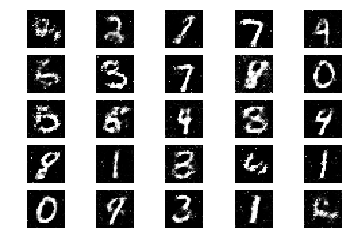

7100 [Discriminator loss: 0.652920, acc.: 60.16%] [Generator loss: 0.788331]
7200 [Discriminator loss: 0.665542, acc.: 64.84%] [Generator loss: 0.836661]
7300 [Discriminator loss: 0.666203, acc.: 60.16%] [Generator loss: 0.820139]
7400 [Discriminator loss: 0.680885, acc.: 57.81%] [Generator loss: 0.804311]
7500 [Discriminator loss: 0.665714, acc.: 62.50%] [Generator loss: 0.778483]


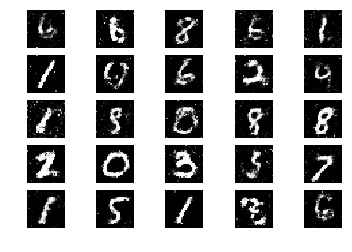

7600 [Discriminator loss: 0.713025, acc.: 49.22%] [Generator loss: 0.836632]
7700 [Discriminator loss: 0.676862, acc.: 52.34%] [Generator loss: 0.752160]
7800 [Discriminator loss: 0.707223, acc.: 53.12%] [Generator loss: 0.790497]
7900 [Discriminator loss: 0.695210, acc.: 50.00%] [Generator loss: 0.828016]
8000 [Discriminator loss: 0.719552, acc.: 48.44%] [Generator loss: 0.778956]


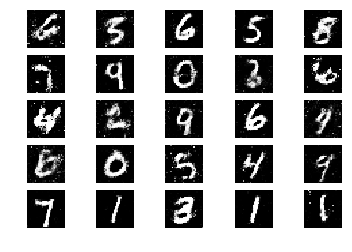

8100 [Discriminator loss: 0.696087, acc.: 54.69%] [Generator loss: 0.846697]
8200 [Discriminator loss: 0.686929, acc.: 50.78%] [Generator loss: 0.822164]
8300 [Discriminator loss: 0.684881, acc.: 57.81%] [Generator loss: 0.818655]
8400 [Discriminator loss: 0.707352, acc.: 46.88%] [Generator loss: 0.794649]
8500 [Discriminator loss: 0.687867, acc.: 50.78%] [Generator loss: 0.811554]


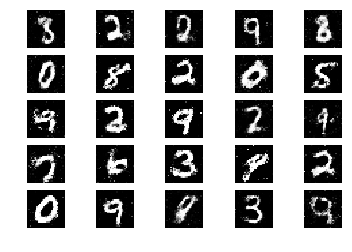

8600 [Discriminator loss: 0.687378, acc.: 53.91%] [Generator loss: 0.806287]
8700 [Discriminator loss: 0.684785, acc.: 53.91%] [Generator loss: 0.810430]
8800 [Discriminator loss: 0.678156, acc.: 53.91%] [Generator loss: 0.796015]
8900 [Discriminator loss: 0.684214, acc.: 57.81%] [Generator loss: 0.815000]
9000 [Discriminator loss: 0.676323, acc.: 53.12%] [Generator loss: 0.835551]


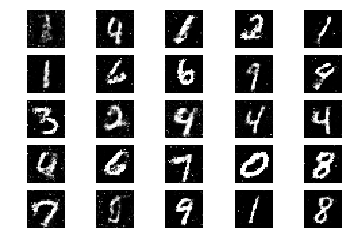

9100 [Discriminator loss: 0.682840, acc.: 60.16%] [Generator loss: 0.795843]
9200 [Discriminator loss: 0.684458, acc.: 54.69%] [Generator loss: 0.775554]
9300 [Discriminator loss: 0.716375, acc.: 48.44%] [Generator loss: 0.774919]
9400 [Discriminator loss: 0.705473, acc.: 56.25%] [Generator loss: 0.805213]
9500 [Discriminator loss: 0.682966, acc.: 54.69%] [Generator loss: 0.793671]


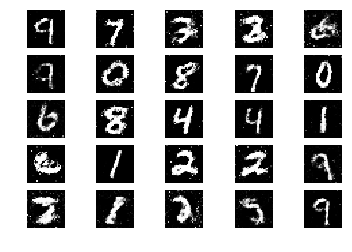

9600 [Discriminator loss: 0.677302, acc.: 57.81%] [Generator loss: 0.843382]
9700 [Discriminator loss: 0.691897, acc.: 51.56%] [Generator loss: 0.822311]
9800 [Discriminator loss: 0.685828, acc.: 56.25%] [Generator loss: 0.808755]
9900 [Discriminator loss: 0.699970, acc.: 48.44%] [Generator loss: 0.816408]


In [10]:
# Now make the call to the Train Function to train the combined model

train(10000, 128, 500)